In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class DAXDataset(Dataset):
    def __init__(self, sequences, targets, headlines_data, sequence_length=15):
        self.sequences = sequences
        self.targets = targets
        self.headlines_data = headlines_data
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor([self.targets[idx]]),
            #'headlines': self.headlines_data[idx]
        }

class DAXLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super(DAXLSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Apply attention
        attn_output, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Use the last output
        out = attn_output[:, -1, :]
        
        # Fully connected layers
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out, attn_weights

class DAXPredictor:
    def __init__(self, sequence_length=15):
        self.sequence_length = sequence_length
        self.model = None
        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()
        self.feature_columns = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
    def load_and_preprocess_data(self, file_path):
        print("Loading data...")
        df = pd.read_parquet(file_path)

        # Flatten multiindex string columns
        import re
        def clean_column(col):
            match = re.match(r"\('([^']*)',", col)
            return match.group(1) if match else col

        df.columns = [clean_column(col) for col in df.columns]

        print("DEBUG columns after cleaning:", df.columns.tolist())

        # Ensure Date column
        if 'Date' not in df.columns:
            raise KeyError(f"'Date' column not found after cleaning. Available: {df.columns.tolist()}")

        df['Date'] = pd.to_datetime(df['Date'])
        if 'news_date' in df.columns:
            df['news_date'] = pd.to_datetime(df['news_date'])

        df = df.sort_values('Date').reset_index(drop=True)

        print(f"Data shape: {df.shape}")
        print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

        return df

     

    
    def create_features(self, df):
        """Create features from DAX data and news sentiment"""
        print("Creating features...")
        
        # DAX technical indicators
        dax_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        
        # Price changes and returns
        df['Price_Change'] = df['Close'] - df['Open']
        df['Price_Return'] = df['Close'].pct_change()
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Volume_MA'] = df['Volume'].rolling(window=5).mean()
        
        # Technical indicators
        df['SMA_5'] = df['Close'].rolling(window=5).mean()
        df['SMA_10'] = df['Close'].rolling(window=10).mean()
        df['EMA_5'] = df['Close'].ewm(span=5).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        df['MACD'] = self.calculate_macd(df['Close'])
        
        # Volatility
        df['Volatility'] = df['Price_Return'].rolling(window=5).std()
        
        # News sentiment aggregation by date
        news_features = self.aggregate_news_sentiment(df)
        
        # Merge news features
        df = df.merge(news_features, left_on='Date', right_on='news_date', how='left')
        
        # Fill missing values
        sentiment_cols = ['daily_pos_score', 'daily_neg_score', 'daily_neu_score', 
                         'daily_sentiment_score', 'news_count', 'sentiment_volatility']
        
        for col in sentiment_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)
        
        # Feature columns for model
        self.feature_columns = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'Price_Change', 'Price_Return', 'High_Low_Ratio',
            'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'MACD', 'Volatility'
        ] + sentiment_cols
        
        # Remove rows with NaN values
        df = df.dropna(subset=self.feature_columns + ['Adj Close'])
        
        print(f"Features created: {len(self.feature_columns)}")
        print(f"Final data shape: {df.shape}")
        
        return df
    
    def calculate_rsi(self, prices, window=14):
        """Calculate RSI indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_macd(self, prices, fast=12, slow=26):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        return macd
    
    def aggregate_news_sentiment(self, df):
        """Aggregate news sentiment by date"""
        news_df = df[['news_date', 'headline_positive_score', 'headline_negative_score', 
                     'headline_neutral_score', 'headline_sentiment_score', 
                     'headline_text_analyzed', 'source_url']].copy()
        
        # Remove duplicates and null values
        news_df = news_df.dropna(subset=['news_date', 'headline_sentiment_score'])
        
        # Group by date and aggregate
        daily_sentiment = news_df.groupby('news_date').agg({
            'headline_positive_score': 'mean',
            'headline_negative_score': 'mean',
            'headline_neutral_score': 'mean',
            'headline_sentiment_score': ['mean', 'std', 'count']
        }).reset_index()
        
        # Flatten column names
        daily_sentiment.columns = ['news_date', 'daily_pos_score', 'daily_neg_score', 
                                 'daily_neu_score', 'daily_sentiment_score', 
                                 'sentiment_volatility', 'news_count']
        
        # Fill NaN std with 0
        daily_sentiment['sentiment_volatility'] = daily_sentiment['sentiment_volatility'].fillna(0)
        
        return daily_sentiment
    
    def create_sequences(self, df):
        """Create sequences for LSTM training"""
        print("Creating sequences...")
        
        features = df[self.feature_columns].values
        targets = df['Adj Close'].values
        
        # Scale features and targets
        features_scaled = self.scaler_features.fit_transform(features)
        targets_scaled = self.scaler_target.fit_transform(targets.reshape(-1, 1)).flatten()
        
        sequences = []
        sequence_targets = []
        headlines_data = []
        
        for i in range(self.sequence_length, len(features_scaled)):
            sequences.append(features_scaled[i-self.sequence_length:i])
            sequence_targets.append(targets_scaled[i])
            
            # Get headlines for this sequence
            start_date = df.iloc[i-self.sequence_length]['Date']
            end_date = df.iloc[i]['Date']
            
            sequence_headlines = df[
                (df['Date'] >= start_date) & (df['Date'] <= end_date)
            ][['Date', 'headline_text_analyzed', 'source_url', 'headline_sentiment_score']].copy()
            
            headlines_data.append(sequence_headlines)
        
        return np.array(sequences), np.array(sequence_targets), headlines_data
    
    def train_model(self, df, epochs=100, batch_size=32, learning_rate=0.001):
        """Train the LSTM model"""
        print("Training model...")
        
        # Create sequences
        sequences, targets, headlines_data = self.create_sequences(df)
        
        # Split data
        train_size = int(0.8 * len(sequences))
        val_size = int(0.1 * len(sequences))
        
        train_sequences = sequences[:train_size]
        train_targets = targets[:train_size]
        train_headlines = headlines_data[:train_size]
        
        val_sequences = sequences[train_size:train_size+val_size]
        val_targets = targets[train_size:train_size+val_size]
        val_headlines = headlines_data[train_size:train_size+val_size]
        
        test_sequences = sequences[train_size+val_size:]
        test_targets = targets[train_size+val_size:]
        test_headlines = headlines_data[train_size+val_size:]
        
        # Create datasets
        train_dataset = DAXDataset(train_sequences, train_targets, train_headlines)
        val_dataset = DAXDataset(val_sequences, val_targets, val_headlines)
        test_dataset = DAXDataset(test_sequences, test_targets, test_headlines)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        input_size = len(self.feature_columns)
        self.model = DAXLSTMPredictor(input_size).to(self.device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            for batch in train_loader:
                sequences = batch['sequence'].to(self.device)
                targets = batch['target'].to(self.device)
                
                optimizer.zero_grad()
                outputs, _ = self.model(sequences)
                loss = criterion(outputs, targets)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    sequences = batch['sequence'].to(self.device)
                    targets = batch['target'].to(self.device)
                    
                    outputs, _ = self.model(sequences)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_dax_model.pth')
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Load best model
        self.model.load_state_dict(torch.load('best_dax_model.pth'))
        
        # Evaluate on test set
        test_predictions, test_actuals, attention_weights = self.evaluate_model(test_loader)
        
        # Store test data for impact analysis
        self.test_headlines = test_headlines
        self.test_predictions = test_predictions
        self.test_actuals = test_actuals
        self.attention_weights = attention_weights
        
        # Calculate metrics
        test_rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        test_mae = mean_absolute_error(test_actuals, test_predictions)
        test_r2 = r2_score(test_actuals, test_predictions)
        
        print(f"\nTest Results:")
        print(f"RMSE: {test_rmse:.4f}")
        print(f"MAE: {test_mae:.4f}")
        print(f"R²: {test_r2:.4f}")
        
        # Now plot
        self.plot_training_curves(train_losses, val_losses)

        
        # Store test data for impact analysis
        self.test_headlines = test_headlines
        self.test_predictions = test_predictions
        self.test_actuals = test_actuals
        self.attention_weights = attention_weights
        
        return self.model
    
    def evaluate_model(self, dataloader):
        """Evaluate model and return predictions with attention weights"""
        self.model.eval()
        predictions = []
        actuals = []
        all_attention_weights = []
        
        with torch.no_grad():
            for batch in dataloader:
                sequences = batch['sequence'].to(self.device)
                targets = batch['target'].to(self.device)
                
                outputs, attention_weights = self.model(sequences)
                
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())
                all_attention_weights.extend(attention_weights.cpu().numpy())
        
        # Inverse transform predictions
        predictions = self.scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        actuals = self.scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
        
        return predictions, actuals, all_attention_weights
    
    def plot_training_curves(self, train_losses, val_losses):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.test_predictions, label='Predictions', alpha=0.7)
        plt.plot(self.test_actuals, label='Actual', alpha=0.7)
        plt.title('Predictions vs Actual (Test Set)')
        plt.xlabel('Time')
        plt.ylabel('DAX Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def find_impactful_headlines(self, top_n=10):
        """Find headlines with most impact on predictions"""
        print(f"\nFinding top {top_n} most impactful headlines...")
        
        impact_scores = []
        
        for i, (pred, actual, attention, headlines) in enumerate(zip(
            self.test_predictions, self.test_actuals, self.attention_weights, self.test_headlines
        )):
            prediction_error = abs(pred - actual)
            
            if not headlines.empty:
                # Calculate impact score for each headline
                for _, headline_row in headlines.iterrows():
                    sentiment_score = headline_row['headline_sentiment_score']
                    if pd.notna(sentiment_score):
                        # Impact score combines prediction error, sentiment strength, and attention
                        impact_score = prediction_error * abs(sentiment_score) * np.mean(attention[0])
                        
                        impact_scores.append({
                            'headline': headline_row['headline_text_analyzed'],
                            'source_url': headline_row['source_url'],
                            'date': headline_row['Date'],
                            'sentiment_score': sentiment_score,
                            'prediction_error': prediction_error,
                            'impact_score': impact_score,
                            'predicted_value': pred,
                            'actual_value': actual
                        })
        
        # Sort by impact score and return top N
        impact_df = pd.DataFrame(impact_scores)
        if not impact_df.empty:
            impact_df = impact_df.sort_values('impact_score', ascending=False).head(top_n)
            
            print("\nTop Impactful Headlines:")
            print("=" * 80)
            for i, row in impact_df.iterrows():
                print(f"\n{i+1}. Impact Score: {row['impact_score']:.4f}")
                print(f"   Date: {row['date']}")
                print(f"   Headline: {row['headline'][:100]}...")
                print(f"   Sentiment: {row['sentiment_score']:.4f}")
                print(f"   Prediction Error: {row['prediction_error']:.2f}")
                print(f"   URL: {row['source_url']}")
                print("-" * 80)
            
            return impact_df
        else:
            print("No impactful headlines found.")
            return pd.DataFrame()
    
    def predict_next_day(self, df, recent_days=15):
        """Predict next day DAX value"""
        print("\nPredicting next day DAX value...")
        
        if self.model is None:
            raise ValueError("Model not trained. Please train the model first.")
        
        # Get the most recent data
        recent_data = df.tail(recent_days)
        
        # Create features
        features = recent_data[self.feature_columns].values
        features_scaled = self.scaler_features.transform(features)
        
        # Create sequence
        sequence = features_scaled.reshape(1, self.sequence_length, -1)
        sequence_tensor = torch.FloatTensor(sequence).to(self.device)
        
        # Make prediction
        self.model.eval()
        with torch.no_grad():
            prediction, attention_weights = self.model(sequence_tensor)
        
        # Inverse transform prediction
        prediction_value = self.scaler_target.inverse_transform(
            prediction.cpu().numpy().reshape(-1, 1)
        )[0][0]
        
        print(f"Predicted DAX value for next day: {prediction_value:.2f}")
        
        return prediction_value, attention_weights.cpu().numpy()

# Usage Example
def main():
    # Initialize predictor
    predictor = DAXPredictor(sequence_length=15)
    
    # Load and preprocess data
    df = predictor.load_and_preprocess_data('dax_final_with_sentiment_granular.parquet')
    
    # Create features
    df = predictor.create_features(df)
    
    # Train model
    model = predictor.train_model(df, epochs=100, batch_size=32)
    
    # Find impactful headlines
    impact_headlines = predictor.find_impactful_headlines(top_n=10)
    
    # Make next day prediction
    next_day_prediction, attention = predictor.predict_next_day(df)
    
    return predictor, impact_headlines, next_day_prediction

if __name__ == "__main__":
    predictor, impact_headlines, prediction = main()
    
    print(f"\nModel training completed!")
    print(f"Next day prediction: {prediction:.2f}")
    print(f"Top impactful headlines saved in 'impact_headlines' variable")

Using device: cuda
Loading data...
DEBUG columns after cleaning: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'news_date', 'headline_text_analyzed', 'source_url', 'matched_company_ticker', 'language_gdelt', 'headline_positive_score', 'headline_negative_score', 'headline_neutral_score', 'headline_sentiment_score', 'headline_dominant_sentiment']
Data shape: (579970, 17)
Date range: 2023-12-01 00:00:00 to 2025-05-12 00:00:00
Creating features...
Features created: 20
Final data shape: (4452, 34)
Training model...
Creating sequences...


KeyboardInterrupt: 


=== LSTM with sequence_length=3 ===
LSTM seq=3 -> RMSE: 5633.52, MAE: 5601.60, R²: -87.491

=== LSTM with sequence_length=4 ===
LSTM seq=4 -> RMSE: 6422.19, MAE: 6394.21, R²: -114.002

=== LSTM with sequence_length=5 ===
LSTM seq=5 -> RMSE: 5405.63, MAE: 5372.36, R²: -80.476

=== LSTM with sequence_length=6 ===
LSTM seq=6 -> RMSE: 4726.50, MAE: 4688.41, R²: -61.290

=== LSTM with sequence_length=7 ===
LSTM seq=7 -> RMSE: 5899.35, MAE: 5868.96, R²: -96.318

=== LSTM with sequence_length=8 ===
LSTM seq=8 -> RMSE: 7114.58, MAE: 7089.42, R²: -140.541

=== LSTM with sequence_length=9 ===
LSTM seq=9 -> RMSE: 5578.95, MAE: 5546.81, R²: -86.034

=== LSTM with sequence_length=10 ===
LSTM seq=10 -> RMSE: 6041.94, MAE: 6012.27, R²: -101.079

=== LSTM with sequence_length=11 ===
LSTM seq=11 -> RMSE: 6290.22, MAE: 6261.73, R²: -109.641

=== LSTM with sequence_length=12 ===
LSTM seq=12 -> RMSE: 5626.04, MAE: 5594.28, R²: -87.767

=== LSTM with sequence_length=13 ===
LSTM seq=13 -> RMSE: 4531.35, MA

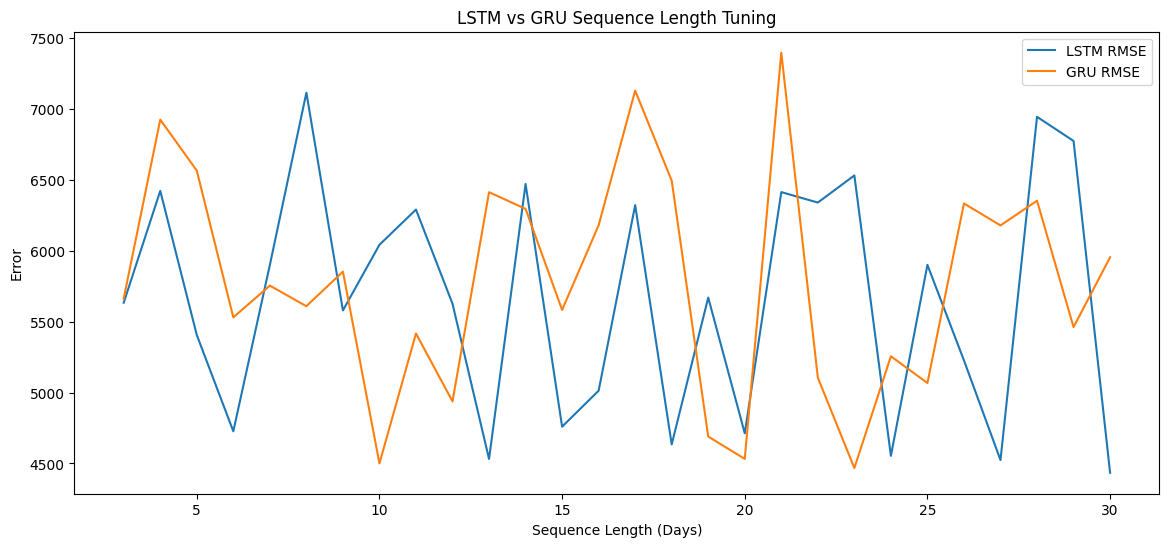


✅ Results saved to 'lstm_gru_sequence_length_comparison.csv'


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# -------------------------------
# Dataset class
# -------------------------------
class DAXDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor([self.targets[idx]])
        }


# -------------------------------
# LSTM or GRU model with Attention
# -------------------------------
class DAXRNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=4, dropout=0.12, use_gru=False):
        super(DAXRNNPredictor, self).__init__()
        if use_gru:
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, 1)
        )

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        attn_out, _ = self.attention(rnn_out, rnn_out, rnn_out)
        out = attn_out[:, -1, :]
        out = self.fc(out)
        return out


# -------------------------------
# DAX Predictor
# -------------------------------
class DAXPredictor:
    def __init__(self, sequence_length, use_gru=False):
        self.sequence_length = sequence_length
        self.use_gru = use_gru
        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def load_and_preprocess_data(self, file_path):
        df = pd.read_parquet(file_path)
        import re
        def clean_column(col):
            match = re.match(r"\('([^']*)',", col)
            return match.group(1) if match else col
        df.columns = [clean_column(col) for col in df.columns]
        df['Date'] = pd.to_datetime(df['Date'])
        if 'news_date' in df.columns:
            df['news_date'] = pd.to_datetime(df['news_date'])
        return df.sort_values('Date').reset_index(drop=True)

    def create_features(self, df):
        df['Price_Change'] = df['Close'] - df['Open']
        df['Price_Return'] = df['Close'].pct_change()
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Volume_MA'] = df['Volume'].rolling(5).mean()
        df['SMA_5'] = df['Close'].rolling(5).mean()
        df['SMA_10'] = df['Close'].rolling(10).mean()
        df['EMA_5'] = df['Close'].ewm(span=5).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        df['MACD'] = self.calculate_macd(df['Close'])
        df['Volatility'] = df['Price_Return'].rolling(5).std()
        self.feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                                'Price_Change', 'Price_Return', 'High_Low_Ratio', 'Volume_MA',
                                'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'MACD', 'Volatility']
        df = df.dropna(subset=self.feature_columns + ['Adj Close'])
        return df

    def calculate_rsi(self, prices, window=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices, fast=12, slow=26):
        return prices.ewm(span=fast).mean() - prices.ewm(span=slow).mean()

    def create_sequences(self, df):
        features = df[self.feature_columns].values
        targets = df['Adj Close'].values.reshape(-1,1)
        features_scaled = self.scaler_features.fit_transform(features)
        targets_scaled = self.scaler_target.fit_transform(targets).flatten()
        sequences, target_vals = [], []
        for i in range(self.sequence_length, len(features_scaled)):
            sequences.append(features_scaled[i-self.sequence_length:i])
            target_vals.append(targets_scaled[i])
        return np.array(sequences), np.array(target_vals)

    def train_and_evaluate(self, df):
        sequences, targets = self.create_sequences(df)
        n_train = int(0.8 * len(sequences))
        n_val = int(0.1 * len(sequences))
        train_ds = DAXDataset(sequences[:n_train], targets[:n_train])
        val_ds = DAXDataset(sequences[n_train:n_train+n_val], targets[n_train:n_train+n_val])
        test_ds = DAXDataset(sequences[n_train+n_val:], targets[n_train+n_val:])
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

        model = DAXRNNPredictor(len(self.feature_columns), use_gru=self.use_gru).to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.00021)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        best_val_loss = float('inf')

        for epoch in range(30):
            model.train()
            train_loss = sum(criterion(model(batch['sequence'].to(self.device)), batch['target'].to(self.device)).item()
                             for batch in train_loader) / len(train_loader)
            model.eval()
            val_loss = sum(criterion(model(batch['sequence'].to(self.device)), batch['target'].to(self.device)).item()
                           for batch in val_loader) / len(val_loader)
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_rnn_model.pth')

        model.load_state_dict(torch.load('best_rnn_model.pth'))
        preds, actuals = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                pred = model(batch['sequence'].to(self.device)).cpu().numpy()
                targ = batch['target'].cpu().numpy()
                preds.extend(pred)
                actuals.extend(targ)
        preds = self.scaler_target.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
        actuals = self.scaler_target.inverse_transform(np.array(actuals).reshape(-1,1)).flatten()
        return preds, actuals


# -------------------------------
# Comparison runner
# -------------------------------
def compare_lstm_gru(df):
    all_results = []
    for rnn_type in ['LSTM', 'GRU']:
        for seq_len in range(3, 31):
            print(f"\n=== {rnn_type} with sequence_length={seq_len} ===")
            use_gru = True if rnn_type == 'GRU' else False
            predictor = DAXPredictor(sequence_length=seq_len, use_gru=use_gru)
            df_features = predictor.create_features(df)
            preds, actuals = predictor.train_and_evaluate(df_features)
            rmse = np.sqrt(mean_squared_error(actuals, preds))
            mae = mean_absolute_error(actuals, preds)
            r2 = r2_score(actuals, preds)
            print(f"{rnn_type} seq={seq_len} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
            all_results.append({
                'model': rnn_type, 'sequence_length': seq_len,
                'rmse': rmse, 'mae': mae, 'r2': r2
            })
    return pd.DataFrame(all_results)


# -------------------------------
# Main run
# -------------------------------
if __name__ == "__main__":
    base_predictor = DAXPredictor(sequence_length=15)
    df = base_predictor.load_and_preprocess_data('dax_final_with_sentiment_granular.parquet')
    results_df = compare_lstm_gru(df)

    # Plot
    plt.figure(figsize=(14,6))
    for model in ['LSTM', 'GRU']:
        sub = results_df[results_df['model']==model]
        plt.plot(sub['sequence_length'], sub['rmse'], label=f'{model} RMSE')
    plt.xlabel("Sequence Length (Days)")
    plt.ylabel("Error")
    plt.title("LSTM vs GRU Sequence Length Tuning")
    plt.legend()
    plt.show()

    # Save to CSV
    results_df.to_csv("lstm_gru_sequence_length_comparison.csv", index=False)
    print("\n✅ Results saved to 'lstm_gru_sequence_length_comparison.csv'")


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import requests
import json
import warnings
warnings.filterwarnings('ignore')


# -------------------------------
# Dataset class (no headlines here)
# -------------------------------
class DAXDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor([self.targets[idx]])
        }


# -------------------------------
# LSTM + Attention
# -------------------------------
class DAXLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=4, dropout=0.12):
        super(DAXLSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        out = attn_out[:, -1, :]
        out = self.fc(out)
        return out, attn_weights


# -------------------------------
# Main class
# -------------------------------
class DAXPredictor:
    def __init__(self, sequence_length=30):
        self.sequence_length = sequence_length
        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_and_preprocess_data(self, file_path):
        df = pd.read_parquet(file_path)
        import re
        def clean_column(col):
            match = re.match(r"\('([^']*)',", col)
            return match.group(1) if match else col
        df.columns = [clean_column(col) for col in df.columns]
        df['Date'] = pd.to_datetime(df['Date'])
        if 'news_date' in df.columns:
            df['news_date'] = pd.to_datetime(df['news_date'])
        return df.sort_values('Date').reset_index(drop=True)

    def create_features(self, df):
        df['Price_Change'] = df['Close'] - df['Open']
        df['Price_Return'] = df['Close'].pct_change()
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Volume_MA'] = df['Volume'].rolling(5).mean()
        df['SMA_5'] = df['Close'].rolling(5).mean()
        df['SMA_10'] = df['Close'].rolling(10).mean()
        df['EMA_5'] = df['Close'].ewm(span=5).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        df['MACD'] = self.calculate_macd(df['Close'])
        df['Volatility'] = df['Price_Return'].rolling(5).std()
        self.feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                                'Price_Change', 'Price_Return', 'High_Low_Ratio', 'Volume_MA',
                                'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'MACD', 'Volatility']
        df = df.dropna(subset=self.feature_columns + ['Adj Close'])
        return df

    def calculate_rsi(self, prices, window=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices, fast=12, slow=26):
        return prices.ewm(span=fast).mean() - prices.ewm(span=slow).mean()

    def create_sequences(self, df):
        features = df[self.feature_columns].values
        targets = df['Adj Close'].values.reshape(-1,1)
        features_scaled = self.scaler_features.fit_transform(features)
        targets_scaled = self.scaler_target.fit_transform(targets).flatten()
        sequences, target_vals, headlines_data = [], [], []
        for i in range(self.sequence_length, len(features_scaled)):
            sequences.append(features_scaled[i-self.sequence_length:i])
            target_vals.append(targets_scaled[i])
            headlines_data.append(df.iloc[i-self.sequence_length:i][['Date', 'headline_text_analyzed', 'source_url', 'headline_sentiment_score']])
        return np.array(sequences), np.array(target_vals), headlines_data

    def train_and_analyze(self, df):
        sequences, targets, headlines_data = self.create_sequences(df)
        n_train = int(0.8 * len(sequences))
        n_val = int(0.1 * len(sequences))

        train_ds = DAXDataset(sequences[:n_train], targets[:n_train])
        val_ds = DAXDataset(sequences[n_train:n_train+n_val], targets[n_train:n_train+n_val])
        test_ds = DAXDataset(sequences[n_train+n_val:], targets[n_train+n_val:])

        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

        model = DAXLSTMPredictor(len(self.feature_columns)).to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.00021)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        best_val_loss = float('inf')

        for epoch in range(100):
            model.train()
            train_loss = sum(criterion(model(batch['sequence'].to(self.device))[0], batch['target'].to(self.device)).item()
                             for batch in train_loader) / len(train_loader)
            model.eval()
            val_loss = sum(criterion(model(batch['sequence'].to(self.device))[0], batch['target'].to(self.device)).item()
                           for batch in val_loader) / len(val_loader)
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'final_best_model.pth')
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Evaluate
        model.load_state_dict(torch.load('final_best_model.pth'))
        model.eval()
        preds, actuals, attentions, headlines_all = [], [], [], []
        idx = n_train + n_val
        with torch.no_grad():
            for batch in test_loader:
                output, attn = model(batch['sequence'].to(self.device))
                preds.extend(output.cpu().numpy())
                actuals.extend(batch['target'].cpu().numpy())
                attentions.extend(attn.cpu().numpy())
                headlines_all.extend(headlines_data[idx:idx+len(batch['sequence'])])
                idx += len(batch['sequence'])
        preds = self.scaler_target.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
        actuals = self.scaler_target.inverse_transform(np.array(actuals).reshape(-1,1)).flatten()

        # Compute impact scores
        impact_scores = []
        for pred, actual, attn, headlines in zip(preds, actuals, attentions, headlines_all):
            error = abs(pred - actual)
            if not headlines.empty:
                for _, row in headlines.iterrows():
                    sentiment = row['headline_sentiment_score']
                    if pd.notna(sentiment):
                        impact_score = error * abs(sentiment) * np.mean(attn[0])
                        impact_scores.append({
                            'headline': row['headline_text_analyzed'],
                            'source_url': row['source_url'],
                            'date': row['Date'],
                            'sentiment': sentiment,
                            'impact_score': impact_score,
                            'predicted': pred,
                            'actual': actual
                        })
        top_headlines = pd.DataFrame(impact_scores).sort_values('impact_score', ascending=False).head(10)
        return top_headlines


# -------------------------------------
# Run final best training + explanation
# -------------------------------------
predictor = DAXPredictor(sequence_length=30)
df = predictor.load_and_preprocess_data('dax_final_with_sentiment_granular.parquet')
df = predictor.create_features(df)
top_headlines = predictor.train_and_analyze(df)

# Explain using Ollama (stream safe)
explanation_prompt = f"Explain why these headlines likely had the biggest impact on DAX prices with sequence length of 30 days:\n\n"
for i, row in top_headlines.iterrows():
    explanation_prompt += f"{i+1}. {row['headline'][:120]}...\n"

response = requests.post(
    "http://localhost:11434/api/generate",
    json={"model":"llama3.2:latest", "prompt": explanation_prompt},
    stream=True
)

full_text = ""
for line in response.iter_lines():
    if line:
        chunk = line.decode('utf-8')
        try:
            obj = json.loads(chunk)
            full_text += obj.get("response", "")
        except json.JSONDecodeError:
            pass

print("\n=== Explanation from LLaMA 3.2 ===")
print(full_text)


Using device: cuda
Epoch 0, Train Loss: 0.044076, Val Loss: 0.224819
Epoch 10, Train Loss: 0.044077, Val Loss: 0.224819
Epoch 20, Train Loss: 0.043999, Val Loss: 0.224819
Epoch 30, Train Loss: 0.044016, Val Loss: 0.224819
Epoch 40, Train Loss: 0.044052, Val Loss: 0.224819
Epoch 50, Train Loss: 0.044147, Val Loss: 0.224819
Epoch 60, Train Loss: 0.044039, Val Loss: 0.224819
Epoch 70, Train Loss: 0.043973, Val Loss: 0.224819
Epoch 80, Train Loss: 0.043944, Val Loss: 0.224819
Epoch 90, Train Loss: 0.044090, Val Loss: 0.224819

=== Explanation from LLaMA 3.2 ===
To analyze why these headlines might have had a significant impact on DAX prices over a 30-day period, let's break down some factors:

1. **Industry Representation**: Many of the headlines relate to the automotive industry (Renault and Citroën), which is one of the largest contributors to the German economy (via the DAX index). News about these companies can have a ripple effect on the market.

2. **Global Events**: The article abou

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import requests
import json
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Dataset & Model
# --------------------------

class DAXDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor([self.targets[idx]])
        }

class DAXLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=4, dropout=0.12):
        super(DAXLSTMPredictor, self).__init__()
        actual_heads = min(8, hidden_size)
        while hidden_size % actual_heads != 0 and actual_heads > 1:
            actual_heads -= 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=actual_heads, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        out = attn_out[:, -1, :]
        out = self.fc(out)
        return out, attn_weights

# --------------------------
# Main prediction class
# --------------------------

class DAXPredictor:
    def __init__(self, sequence_length=30):
        self.sequence_length = sequence_length
        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_data(self, path):
        df = pd.read_parquet(path)
        import re
        df.columns = [re.match(r"\('([^']*)',", col).group(1) if re.match(r"\('([^']*)',", col) else col for col in df.columns]
        df['Date'] = pd.to_datetime(df['Date'])
        if 'news_date' in df.columns:
            df['news_date'] = pd.to_datetime(df['news_date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # Remove duplicate dates by taking first occurrence
        df = df.groupby('Date').first().reset_index()

        # Handle missing dates - reindex to continuous business days
        all_days = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='B')
        df = df.set_index('Date').reindex(all_days)

        # Forward fill market data and news columns
        df[['Open','High','Low','Close','Adj Close','Volume']] = df[['Open','High','Low','Close','Adj Close','Volume']].ffill()
        df['headline_text_analyzed'] = df['headline_text_analyzed'].ffill()
        df['source_url'] = df['source_url'].ffill()
        df = df.reset_index().rename(columns={'index': 'Date'})
        return df

    def create_features(self, df):
        df['Price_Change'] = df['Close'] - df['Open']
        df['Price_Return'] = df['Close'].pct_change()
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Volume_MA'] = df['Volume'].rolling(5, min_periods=1).mean()
        df['SMA_5'] = df['Close'].rolling(5, min_periods=1).mean()
        df['SMA_10'] = df['Close'].rolling(10, min_periods=1).mean()
        df['EMA_5'] = df['Close'].ewm(span=5, min_periods=1).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        df['MACD'] = self.calculate_macd(df['Close'])
        df['Volatility'] = df['Price_Return'].rolling(5, min_periods=1).std()
        self.feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'Price_Return',
                                'High_Low_Ratio', 'Volume_MA', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'MACD', 'Volatility']
        return df.dropna(subset=self.feature_columns + ['Adj Close'])

    def calculate_rsi(self, prices, window=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=window, min_periods=1).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window, min_periods=1).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices, fast=12, slow=26):
        return prices.ewm(span=fast, min_periods=1).mean() - prices.ewm(span=slow, min_periods=1).mean()

    def create_sequences(self, df):
        features = df[self.feature_columns].values
        targets = df['Adj Close'].values.reshape(-1,1)
        features_scaled = self.scaler_features.fit_transform(features)
        targets_scaled = self.scaler_target.fit_transform(targets).flatten()
        sequences, target_vals, headlines = [], [], []
        for i in range(self.sequence_length, len(features_scaled)):
            window_seq = features_scaled[i-self.sequence_length:i]
            if np.isnan(window_seq).any():
                continue
            sequences.append(window_seq)
            target_vals.append(targets_scaled[i])
            headlines.append(df.iloc[i-self.sequence_length:i][['Date', 'headline_text_analyzed', 'source_url']])
        return np.array(sequences), np.array(target_vals), headlines

    def train_full(self, df):
        sequences, targets, headlines_data = self.create_sequences(df)
        dataset = DAXDataset(sequences, targets)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        model = DAXLSTMPredictor(len(self.feature_columns)).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=0.00021)
        criterion = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

        for epoch in range(150):
            model.train()
            total_loss = 0
            for batch in loader:
                optimizer.zero_grad()
                out, _ = model(batch['sequence'].to(self.device))
                loss = criterion(out, batch['target'].to(self.device))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(loader)
            scheduler.step(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")

        torch.save(model.state_dict(), 'best_dax_model_final.pth')
        print("✅ Model saved to best_dax_model_final.pth")
        return model, sequences, targets, headlines_data

    def find_impactful_headlines(self, model, sequences, targets, headlines_data):
        model.eval()
        impact_scores = []

        with torch.no_grad():
            for seq, target, headlines in zip(sequences, targets, headlines_data):
                seq_t = torch.FloatTensor(seq).unsqueeze(0).to(self.device)
                pred, attn = model(seq_t)
                pred_val = self.scaler_target.inverse_transform(pred.cpu().numpy())[0][0]
                actual_val = self.scaler_target.inverse_transform([[target]])[0][0]
                error = abs(pred_val - actual_val)
                mean_attention = attn.mean().item()

                for _, row in headlines.iterrows():
                    impact = error * abs(mean_attention)
                    impact_scores.append({
                        'headline': row['headline_text_analyzed'],
                        'url': row.get('source_url', ''),
                        'date': row['Date'],
                        'impact': impact
                    })

        df_impact = pd.DataFrame(impact_scores).sort_values('impact', ascending=False).drop_duplicates('headline')
        return df_impact.head(10)

    def predict_next_day(self, model, sequences, headlines_data, df):
        last_seq = sequences[-1].reshape(1, self.sequence_length, -1)
        next_day_pred, _ = model(torch.FloatTensor(last_seq).to(self.device))
        next_day_price = self.scaler_target.inverse_transform(next_day_pred.cpu().detach().numpy())[0][0]
        pred_date = df['Date'].iloc[-1] + timedelta(days=1)
        return next_day_price, pred_date, headlines_data[-1]

# --------------------------
# Run everything
# --------------------------

predictor = DAXPredictor(sequence_length=30)
df = predictor.load_data('dax_final_with_sentiment_granular.parquet')
df = predictor.create_features(df)
model, sequences, targets, headlines_data = predictor.train_full(df)

# Most impactful headlines
impact_df = predictor.find_impactful_headlines(model, sequences, targets, headlines_data)
print("\n=== Top 10 most impactful headlines ===")
for i, row in impact_df.iterrows():
    print(f"{i+1}. {row['date'].date()} - {row['headline'][:100]}... [Link: {row['url']}] (Impact: {row['impact']:.4f})")

# Predict next day
next_price, pred_date, headlines_used = predictor.predict_next_day(model, sequences, headlines_data, df)
print(f"\nPredicted DAX for {pred_date.date()}: {next_price:.2f}")

# Send to Ollama
prompt = f"Explain why these top 10 headlines had the most impact on the DAX prediction:\n"
for i, row in impact_df.iterrows():
    prompt += f"- {row['date'].date()}: {row['headline'][:120]}... (Link: {row['url']})\n"

response = requests.post(
    "http://localhost:11434/api/generate",
    json={"model":"llama3.2:latest", "prompt": prompt},
    stream=True
)

full_text = ""
for line in response.iter_lines():
    if line:
        try:
            obj = json.loads(line.decode())
            full_text += obj.get("response", "")
        except:
            pass

print("\n=== Explanation from LLaMA 3.2 ===")
print(full_text)


Using device: cuda
Epoch 0, Avg Loss: 0.251511
Epoch 10, Avg Loss: 0.013916
Epoch 20, Avg Loss: 0.009969
Epoch 30, Avg Loss: 0.007879
Epoch 40, Avg Loss: 0.007783
Epoch 50, Avg Loss: 0.007459
Epoch 60, Avg Loss: 0.008102
Epoch 70, Avg Loss: 0.007317
Epoch 80, Avg Loss: 0.007918
Epoch 90, Avg Loss: 0.007337
Epoch 100, Avg Loss: 0.007250
Epoch 110, Avg Loss: 0.008011
Epoch 120, Avg Loss: 0.007534
Epoch 130, Avg Loss: 0.008512
Epoch 140, Avg Loss: 0.007491
✅ Model saved to best_dax_model_final.pth

=== Top 10 most impactful headlines ===
4334. 2024-07-11 - whittier trust co. raises position in lockheed martin co. (nyse:lmt)... [Link: https://www.dailypolitical.com/2024/07/09/whittier-trust-co-raises-position-in-lockheed-martin-co-nyselmt.html] (Impact: 36.8096)
4321. 2024-06-24 - victoria business | business and finance news... [Link: https://www.themercury.com.au/business/victoria-business?nk=ef5a324f37a544b639f526a1344e2f1c-1719149484] (Impact: 36.8096)
4348. 2024-07-31 - the right to d

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta, datetime
import requests
import json
import warnings
warnings.filterwarnings('ignore')


class DAXDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor([self.targets[idx]])
        }


class DAXLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=4, dropout=0.12):
        super(DAXLSTMPredictor, self).__init__()
        actual_heads = min(8, hidden_size)
        while hidden_size % actual_heads != 0 and actual_heads > 1:
            actual_heads -= 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=actual_heads, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        out = attn_out[:, -1, :]
        out = self.fc(out)
        return out, attn_weights


class DAXPredictor:
    def __init__(self, sequence_length=30):
        self.sequence_length = sequence_length
        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_data(self, path):
        df = pd.read_parquet(path)
        import re
        df.columns = [re.match(r"\('([^']*)',", col).group(1) if re.match(r"\('([^']*)',", col) else col for col in df.columns]
        df['Date'] = pd.to_datetime(df['Date'])
        if 'news_date' in df.columns:
            df['news_date'] = pd.to_datetime(df['news_date'])
        return df.sort_values('Date').reset_index(drop=True)

    def is_trading_day(self, date):
        """Check if a given date is a trading day (not weekend or common German holidays)"""
        # Convert to datetime if it's a string
        if isinstance(date, str):
            date = pd.to_datetime(date)
        
        # Check if it's a weekend
        if date.weekday() >= 5:  # Saturday = 5, Sunday = 6
            return False
        
        # Common German holidays that affect DAX trading
        year = date.year
        german_holidays = [
            f"{year}-01-01",  # New Year's Day
            f"{year}-01-06",  # Epiphany
            f"{year}-05-01",  # Labour Day
            f"{year}-10-03",  # German Unity Day
            f"{year}-12-24",  # Christmas Eve
            f"{year}-12-25",  # Christmas Day
            f"{year}-12-26",  # Boxing Day
            f"{year}-12-31",  # New Year's Eve
        ]
        
        # Convert to datetime for comparison
        german_holidays = [pd.to_datetime(holiday) for holiday in german_holidays]
        
        # Check if current date is a holiday
        return date not in german_holidays

    def get_next_trading_day(self, date):
        """Get the next trading day after the given date"""
        if isinstance(date, str):
            date = pd.to_datetime(date)
        
        next_day = date + timedelta(days=1)
        while not self.is_trading_day(next_day):
            next_day += timedelta(days=1)
        return next_day

    def get_previous_trading_day(self, date):
        """Get the previous trading day before the given date"""
        if isinstance(date, str):
            date = pd.to_datetime(date)
        
        prev_day = date - timedelta(days=1)
        while not self.is_trading_day(prev_day):
            prev_day -= timedelta(days=1)
        return prev_day

    def fill_missing_trading_days(self, df):
        """Fill missing trading days with forward-filled values"""
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Get the date range
        start_date = df['Date'].min()
        end_date = df['Date'].max()
        
        # Create a complete date range for trading days only
        all_dates = []
        current_date = start_date
        while current_date <= end_date:
            if self.is_trading_day(current_date):
                all_dates.append(current_date)
            current_date += timedelta(days=1)
        
        # Create a complete dataframe with all trading days
        complete_df = pd.DataFrame({'Date': all_dates})
        
        # Merge with existing data
        df_complete = complete_df.merge(df, on='Date', how='left')
        
        # Forward fill missing values for price data
        price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in price_columns:
            if col in df_complete.columns:
                df_complete[col] = df_complete[col].fillna(method='ffill')
        
        # For headlines, use empty string for missing days
        if 'headline_text_analyzed' in df_complete.columns:
            df_complete['headline_text_analyzed'] = df_complete['headline_text_analyzed'].fillna('')
        
        if 'source_url' in df_complete.columns:
            df_complete['source_url'] = df_complete['source_url'].fillna('')
        
        print(f"Original data: {len(df)} rows, Complete data: {len(df_complete)} rows")
        print(f"Added {len(df_complete) - len(df)} missing trading days")
        
        return df_complete

    def create_features(self, df):
        # Fill missing trading days first
        df = self.fill_missing_trading_days(df)
        
        df['Price_Change'] = df['Close'] - df['Open']
        df['Price_Return'] = df['Close'].pct_change()
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Volume_MA'] = df['Volume'].rolling(5).mean()
        df['SMA_5'] = df['Close'].rolling(5).mean()
        df['SMA_10'] = df['Close'].rolling(10).mean()
        df['EMA_5'] = df['Close'].ewm(span=5).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        df['MACD'] = self.calculate_macd(df['Close'])
        df['Volatility'] = df['Price_Return'].rolling(5).std()
        
        # Add day of week feature to help model understand trading patterns
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        
        # Add feature to indicate if previous day was non-trading day
        df['DaysFromLastTrade'] = 1
        for i in range(1, len(df)):
            days_diff = (df['Date'].iloc[i] - df['Date'].iloc[i-1]).days
            df.loc[df.index[i], 'DaysFromLastTrade'] = days_diff
        
        self.feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'Price_Return',
                                'High_Low_Ratio', 'Volume_MA', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'MACD', 
                                'Volatility', 'DayOfWeek', 'DaysFromLastTrade']
        
        return df.dropna(subset=self.feature_columns + ['Adj Close'])

    def calculate_rsi(self, prices, window=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices, fast=12, slow=26):
        return prices.ewm(span=fast).mean() - prices.ewm(span=slow).mean()

    def create_sequences(self, df):
        features = df[self.feature_columns].values
        targets = df['Adj Close'].values.reshape(-1,1)
        features_scaled = self.scaler_features.fit_transform(features)
        targets_scaled = self.scaler_target.fit_transform(targets).flatten()
        sequences, target_vals, headlines = [], [], []
        
        for i in range(self.sequence_length, len(features_scaled)):
            sequences.append(features_scaled[i-self.sequence_length:i])
            target_vals.append(targets_scaled[i])
            headlines.append(df.iloc[i-self.sequence_length:i][['Date', 'headline_text_analyzed', 'source_url']])
        
        return np.array(sequences), np.array(target_vals), headlines

    def train_full(self, df):
        sequences, targets, headlines_data = self.create_sequences(df)
        dataset = DAXDataset(sequences, targets)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        model = DAXLSTMPredictor(len(self.feature_columns)).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=0.00021)
        criterion = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

        for epoch in range(150):
            model.train()
            total_loss = 0
            for batch in loader:
                optimizer.zero_grad()
                out, _ = model(batch['sequence'].to(self.device))
                loss = criterion(out, batch['target'].to(self.device))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(loader)
            scheduler.step(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")

        torch.save(model.state_dict(), 'best_dax_model_final.pth')
        print("✅ Model saved to best_dax_model_final.pth")
        return model, sequences, targets, headlines_data

    def find_impactful_headlines(self, model, sequences, targets, headlines_data):
        model.eval()
        predictions, impact_scores = [], []

        with torch.no_grad():
            for seq, target, headlines in zip(sequences, targets, headlines_data):
                seq_t = torch.FloatTensor(seq).unsqueeze(0).to(self.device)
                pred, attn = model(seq_t)
                pred_val = self.scaler_target.inverse_transform(pred.cpu().numpy())[0][0]
                actual_val = self.scaler_target.inverse_transform([[target]])[0][0]
                error = abs(pred_val - actual_val)
                mean_attention = attn.mean().item()

                for _, row in headlines.iterrows():
                    # Skip empty headlines from filled missing days
                    if row.get('headline_text_analyzed', '').strip():
                        sentiment = row.get('headline_text_analyzed', '')
                        impact = error * abs(mean_attention)
                        impact_scores.append({
                            'headline': row['headline_text_analyzed'],
                            'url': row.get('source_url', ''),
                            'date': row['Date'],
                            'impact': impact
                        })

        df_impact = pd.DataFrame(impact_scores).sort_values('impact', ascending=False).drop_duplicates('headline')
        return df_impact.head(10)

    def predict_next_day(self, model, sequences, headlines_data, df):
        """Predict the next trading day price"""
        last_seq = sequences[-1].reshape(1, self.sequence_length, -1)
        next_day_pred, _ = model(torch.FloatTensor(last_seq).to(self.device))
        next_day_price = self.scaler_target.inverse_transform(next_day_pred.cpu().detach().numpy())[0][0]
        
        # Get the actual next trading day
        last_date = df['Date'].iloc[-1]
        next_trading_day = self.get_next_trading_day(last_date)
        
        return next_day_price, next_trading_day, headlines_data[-1]


# --------------------------
# Run everything
# --------------------------
predictor = DAXPredictor(sequence_length=30)
df = predictor.load_data('dax_final_with_sentiment_granular.parquet')
df = predictor.create_features(df)
model, sequences, targets, headlines_data = predictor.train_full(df)

# Most impactful headlines
impact_df = predictor.find_impactful_headlines(model, sequences, targets, headlines_data)
print("\n=== Top 10 most impactful headlines ===")
for i, row in impact_df.iterrows():
    print(f"{i+1}. {row['date'].date()} - {row['headline'][:100]}... [Link: {row['url']}] (Impact: {row['impact']:.4f})")

# Predict next day
next_price, pred_date, headlines_used = predictor.predict_next_day(model, sequences, headlines_data, df)
print(f"\nPredicted DAX for next trading day ({pred_date.date()}): {next_price:.2f}")

# Check if prediction date is a trading day
if predictor.is_trading_day(pred_date):
    print(f"✅ {pred_date.date()} is a trading day")
else:
    print(f"⚠️  {pred_date.date()} is not a trading day")

# Send to Ollama
prompt = f"Explain why these top 10 headlines had the most impact on the DAX prediction:\n"
for i, row in impact_df.iterrows():
    prompt += f"- {row['date'].date()}: {row['headline'][:120]}... (Link: {row['url']})\n"

try:
    response = requests.post(
        "http://localhost:11434/api/generate",
        json={"model":"llama3.2:latest", "prompt": prompt},
        stream=True
    )

    full_text = ""
    for line in response.iter_lines():
        if line:
            try:
                obj = json.loads(line.decode())
                full_text += obj.get("response", "")
            except:
                pass

    print("\n=== Explanation from LLaMA 3.2 ===")
    print(full_text)
    
except requests.exceptions.ConnectionError:
    print("\n⚠️  Could not connect to Ollama. Please ensure Ollama is running on localhost:11434")
except Exception as e:
    print(f"\n⚠️  Error connecting to Ollama: {e}")

Using device: cuda
Original data: 579970 rows, Complete data: 577909 rows
Added -2061 missing trading days
Epoch 0, Avg Loss: 0.064608
Epoch 10, Avg Loss: 0.003229
Epoch 20, Avg Loss: 0.002374
Epoch 30, Avg Loss: 0.001805
Epoch 40, Avg Loss: 0.001494
Epoch 50, Avg Loss: 0.001198
Epoch 60, Avg Loss: 0.001235
Epoch 70, Avg Loss: 0.001005
Epoch 80, Avg Loss: 0.000907
Epoch 90, Avg Loss: 0.000862
Epoch 100, Avg Loss: 0.000851
Epoch 110, Avg Loss: 0.000749
Epoch 120, Avg Loss: 0.000757
Epoch 130, Avg Loss: 0.000713
Epoch 140, Avg Loss: 0.000760
✅ Model saved to best_dax_model_final.pth

=== Top 10 most impactful headlines ===
125110. 2025-02-11 - 2025 bmw m5 review... [Link: https://www.sconeadvocate.com.au/story/8888064/2025-bmw-m5-review/?cs=34616] (Impact: 16.8150)
125118. 2025-02-12 - ethanol petrol blending increasing to 20 percent by october 2025, e20 fuel... [Link: https://www.autocarindia.com:443/industry/india-on-target-to-achieve-20-percent-ethanol-blending-by-october-2025-pm-modi